In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

from pathlib import Path
from tensorflow.keras.models import load_model

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

model = load_model('C:\\Users\\ABHAY VERMA\\Documents\\Linguistic\\models\\saved_models\\captcha_recognition.h5')

In [2]:
image_paths = list(map(str, list(Path("C:\\Users\\ABHAY VERMA\\Documents\\Linguistic\\data\\Captcha_Recognition\\test_samples").glob("*.png"))))

characters = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L',
              'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h',
              'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']

print("Total Test Samples : ", len(image_paths))

Total Test Samples :  16


In [3]:
AUTOTUNE = tf.data.AUTOTUNE

char_to_num = layers.StringLookup(vocabulary=list(characters), mask_token=None)

num_to_char = layers.StringLookup(vocabulary=char_to_num.get_vocabulary(), mask_token=None, invert=True)

In [4]:
batch_size = 16

img_width = 200
img_height = 50

def preprocess_image(img_path):
    img = tf.io.read_file(img_path)
    img = tf.io.decode_png(img, channels=1)
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = tf.image.resize(img, [img_height, img_width])
    img = tf.transpose(img, perm=[1, 0, 2])
    return img

def process_images(image_path):
    image = preprocess_image(image_path)
    return image

def prepare_dataset(image_paths):
    dataset = tf.data.Dataset.from_tensor_slices(image_paths).map(process_images, num_parallel_calls=AUTOTUNE)
    return dataset.batch(batch_size).cache().prefetch(AUTOTUNE)

In [5]:
test_ds = prepare_dataset(image_paths)

1/1 [==============================] - 1s 1s/step


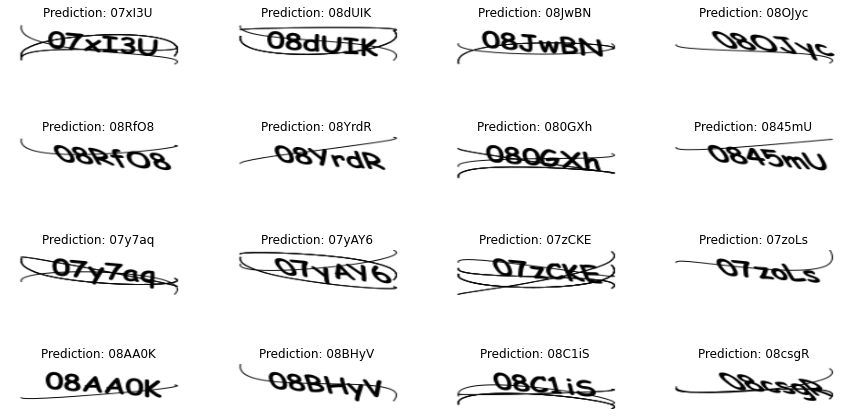

In [6]:
def decode_batch_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    results = keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0]
    result = ''
    output_text = []
    for result in results:
        result = tf.strings.reduce_join(num_to_char(result)).numpy().decode("utf-8")
        res = ''
        for i in result:
            if i == '[':
                break
            res += i
        output_text.append(res)
    return output_text

for batch in test_ds.take(1):
    _, ax = plt.subplots(4, 4, figsize=(15, 8))
    
    preds = model.predict(batch)
    pred_texts = decode_batch_predictions(preds)
    
    for i in range(len(pred_texts)):
        img = (batch[i, :, :, 0] * 255).numpy().astype(np.uint8)
        img = img.T
        title = f"Prediction: {pred_texts[i]}"
        ax[i // 4, i % 4].imshow(img, cmap="gray")
        ax[i // 4, i % 4].set_title(title)
        ax[i // 4, i % 4].axis("off")
plt.show()

In [7]:
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 image (InputLayer)          [(None, 200, 50, 1)]      0         
                                                                 
 Conv1 (Conv2D)              (None, 200, 50, 32)       320       
                                                                 
 pool1 (MaxPooling2D)        (None, 100, 25, 32)       0         
                                                                 
 Conv2 (Conv2D)              (None, 100, 25, 64)       18496     
                                                                 
 pool2 (MaxPooling2D)        (None, 50, 12, 64)        0         
                                                                 
 reshape (Reshape)           (None, 50, 768)           0         
                                                                 
 dense1 (Dense)              (None, 50, 64)            4921